In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Formatting dates
import plotly.graph_objects as ob
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings

import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv
# from datetime import datetime
import math

warnings.simplefilter('ignore')
%matplotlib notebook
# sns.set_style('darkgrid')
plt.style.use('dark_background')
fig = plt.rc("figure", figsize=(8, 5))
plt.rc("savefig", dpi=90)

In [ ]:
# IMPORTING FROM LOCAL DRIVE

df = pd.read_csv(r'C:\Users\UBONG\Desktop\DATA\Gold\XAUUSD_M15_202001012300_202402290300.csv',
                 delimiter = '\t')
df.columns = ['Date','Time','open','high','low','close','TickVol','volume','Spread']
df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['average_price'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df = df.drop(columns=['Date','Time','Spread','TickVol'])
df.set_index("time", inplace=True)

df

In [ ]:
def createFeatures(data):
    data = pd.DataFrame(data)
    
    data['Close Diff'] = data['average_price'].diff()
    
    # THE MAs ARE MODELLED TO THE 15MINUTES TIMEFRAME
    data['MA1920'] = data['close'].rolling(window=1920).mean()### EACH 15MINUTES IN ONE MONTH 
    data['MA480'] = data['close'].rolling(window=480).mean()### EACH 15MINUTES IN 5 TRADING DAYS
    data['MA96'] = data['close'].rolling(window=96).mean()### EACH 15MINUTES IN A TRADING DAY
    data['MA24'] = data['close'].rolling(window=24).mean()### EACH 15MINUTES IN 4 HOURS TIMEFRAME
    data['MA4'] = data['close'].rolling(window=4).mean()### EACH 15MINUTES IN 1 HOUR TIMEFRAME
    data['MA1'] = data['close'].rolling(window=1).mean()### LAST 15MINUTES 
    
    data['Diff-MA1920-MA96'] = data['MA1920'] - data['MA96']
    data['Diff-MA1920-MA480'] = data['MA1920'] - data['MA480']
    data['Diff-MA1920-CLOSE'] = data['MA1920'] - data['close']
    data['Diff-MA480-CLOSE'] = data['MA480'] - data['close']
    data['Diff-MA96-CLOSE'] = data['MA96'] - data['close']
    
    data['MA1920_low'] = data['low'].rolling(window=1920).min()
    data['MA24_low'] = data['low'].rolling(window=24).min()
    data['MA1920_high'] = data['high'].rolling(window=1920).max()
    data['MA24_high'] = data['low'].rolling(window=24).max()
    data['MA4daySTD'] = data['close'].rolling(window=4).std()
    
    data['EMA1920'] = data['close'].ewm(span=1920, adjust=False).mean()
    data['EMA480'] = data['close'].ewm(span=480, adjust=False).mean()
    data['EMA96'] = data['close'].ewm(span=96, adjust=False).mean()
    data['EMA24'] = data['close'].ewm(span=24, adjust=False).mean()
    data['EMA4'] = data['close'].ewm(span=4, adjust=False).mean()
    
    data['close_shift-1'] = data.shift(-1)['close']
    data['close_shift-2'] = data.shift(-2)['close']
    
    data['Bollinger_Upper'] = data['MA4'] + (data['MA4daySTD'] * 2)
    data['Bollinger_Lower'] = data['MA4'] - (data['MA4daySTD'] * 2)
    
    data['K-ratio'] = 100 * ((data['close'] - data['MA24_low']) /
                            (data['MA24_high'] - data['MA24_low']))
    
    data['MACD'] = data['EMA480'] - data['EMA24']
    
    nareplace = data.at[data.index.max(), 'close']
    data.fillna((nareplace), inplace = True)
    
    return data

In [ ]:
df = createFeatures(df)
df.info()

In [ ]:
df.head()

In [ ]:
def filter_data(df):
    train_df = df.sort_values(by=['time']).copy()
    FEATURES = ['volume','high','low','open','Bollinger_Upper','Bollinger_Lower', 'close', 'average_price']
    print('FEATURES LIST')
    print([f for f in FEATURES])
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    return data_filtered
data_filtered = filter_data(df)
data_filtered

In [ ]:
data_filtered.corr()['close']

In [ ]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.7)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df, split_index

In [ ]:
train_data, test_data, split = train_test_split(data_filtered)
test_data

In [ ]:
def preprocess_data(data):
    nrows = data.shape[0]
    
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)
    
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    
    return np_data_scaled,scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)

In [ ]:
def partition_dataset(sequence_length, data):
    x, y = [],[]
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i,:])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [ ]:
sequence_length = 120
x_train, y_train = partition_dataset(sequence_length,train_data_scaled)
x_test, y_test = partition_dataset(sequence_length,test_data_scaled)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_test,y_train)


In [ ]:
print(x_train[1][sequence_length-1][-1])
print(y_train[0][-1])

In [ ]:
out = y_test.shape[1]
model = Sequential()
model.add(LSTM(128, input_shape = (x_train.shape[1], x_train.shape[2]),
                                  return_sequences=True, activation='relu'))
model.add(Dropout(0,3))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(out))

optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss='mean_squared_error')

In [ ]:
model.summary()

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5,mode='min')
history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5,
    batch_size = 32,
    callbacks = [early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'C:\\Users\\UBONG\\Desktop\\ML PROJECTS\\PY ML\\MultiVar_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

2128/2128 [==============================] - 481s 224ms/step - loss: 0.0059 - val_loss: 4.5869e-04
Epoch 2/5
2128/2128 [==============================] - 441s 207ms/step - loss: 9.2062e-04 - val_loss: 5.0818e-04
Epoch 3/5
2128/2128 [==============================] - 417s 196ms/step - loss: 8.3266e-04 - val_loss: 5.1003e-04
Epoch 4/5
2128/2128 [==============================] - 430s 202ms/step - loss: 8.0742e-04 - val_loss: 5.0737e-04
Epoch 5/5
2128/2128 [==============================] - 426s 200ms/step - loss: 7.9543e-04 - val_loss: 4.6970e-04


<IPython.core.display.Javascript object>


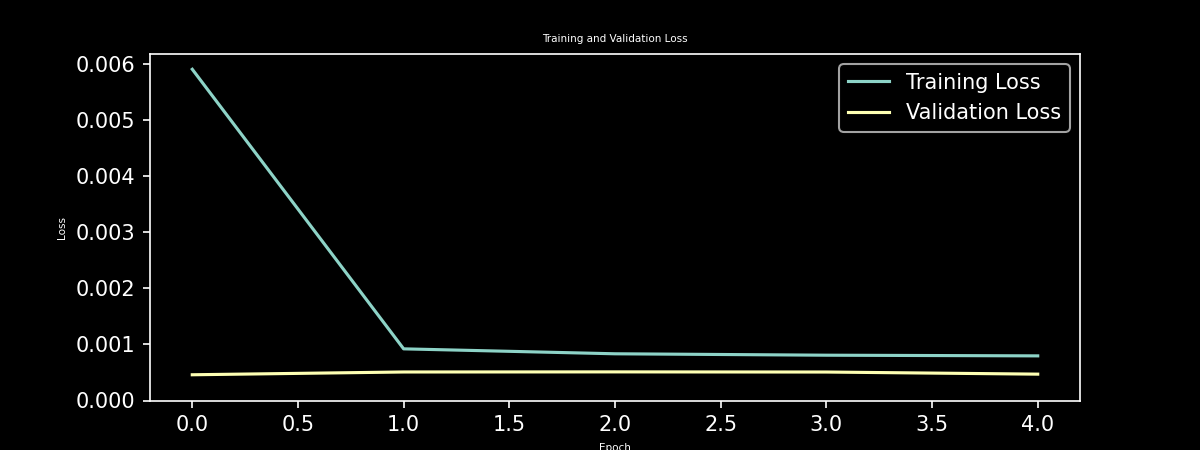

In [17]:
plt.figure(figsize=(8,3))
# plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=5)
plt.ylabel('Loss', fontsize=5)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize = 5)
plt.show()

In [18]:
test_predict = model.predict(x_test)

913/913 [==============================] - 55s 59ms/step


In [19]:
test_predict = scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test)
test_predict.shape

(29210, 8)

In [20]:
i = out - 1
RMSE = math.sqrt(mean_squared_error(y_test_unscaled[:,i],
                                   test_predict[:,i]))
print(f'Root Mean Squared Error(RMSE): {np.round(RMSE, 3)}')

MAE = mean_absolute_error(y_test_unscaled[:,i], test_predict[:,i])
print(f'Mean Absolute Error (MAE): {np.round(MAE, 3)}')

MAPE = np.mean(np.abs(np.subtract(y_test_unscaled[:, i],
                                  test_predict[:,i])/y_test_unscaled[:,i]))*100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 3)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:,i],
                                      test_predict[:,i])/y_test_unscaled[:,i])))*100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 3)} %')

Root Mean Squared Error(RMSE): 5.578
Mean Absolute Error (MAE): 4.35
Mean Absolute Percentage Error (MAPE): 0.225 %
Median Absolute Percentage Error (MDAPE): 0.186 %


In [26]:
Train = data_filtered[:split]
valid = data_filtered[split:]
valid['Predictions'] = test_predict[:,out-1]
valid

ValueError: Length of values (29210) does not match length of index (29230)

<IPython.core.display.Javascript object>


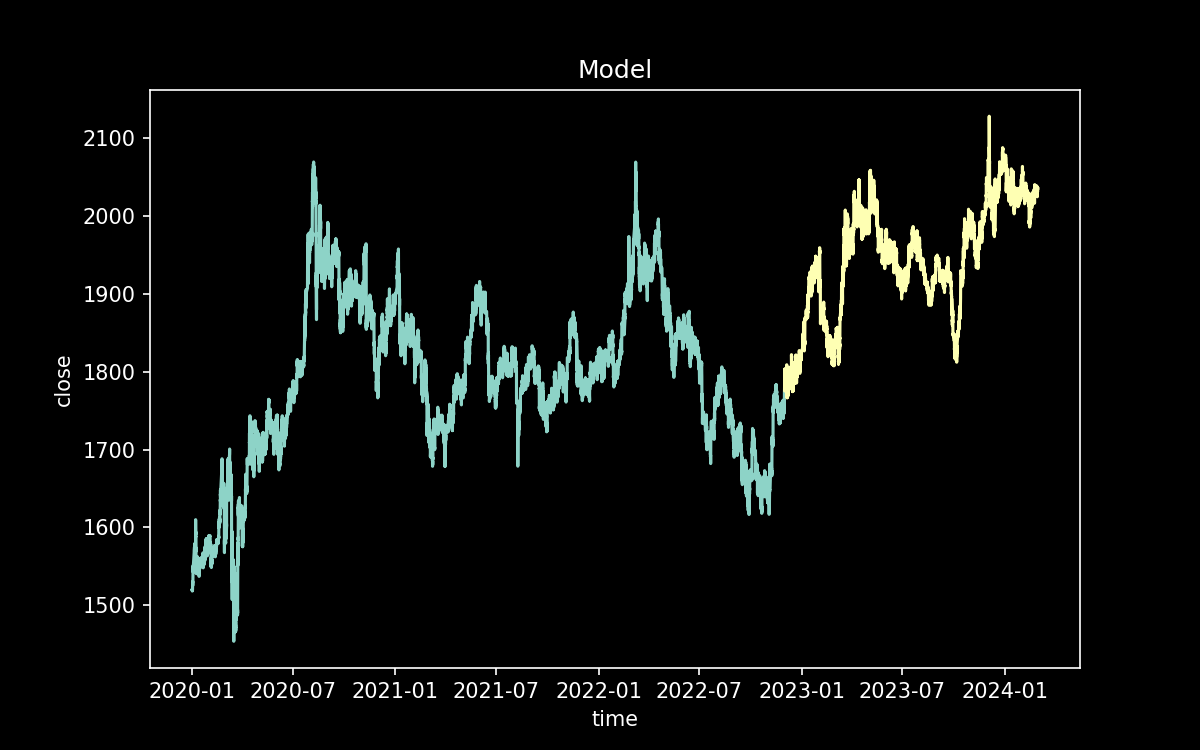

KeyError: 'Predictions'

In [24]:
plt.figure(figsize = (8,5))
plt.title("Model")
plt.xlabel('time')
plt.ylabel('close')

plt.plot(Train['close'])
plt.plot(valid['close'])
plt.plot(valid['Predictions'])

plt.legend(['Train','Val','Prediction'], loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


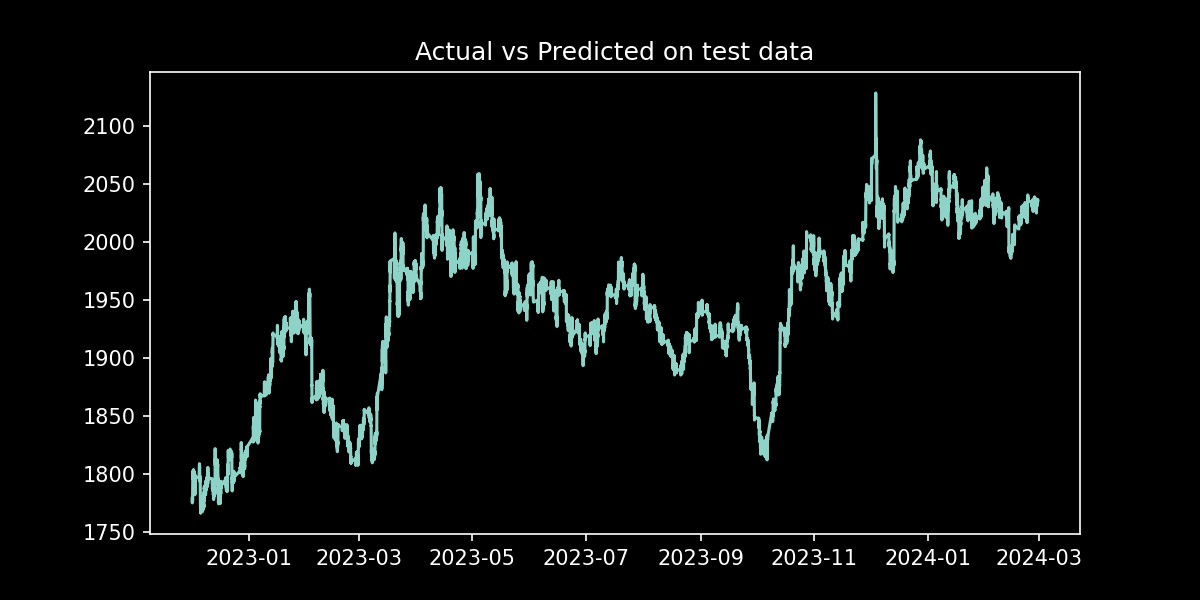

KeyError: 'Predictions'

In [25]:
plt.figure(figsize=(8,4))
plt.title('Actual vs Predicted on test data')
plt.plot(valid['close'])
plt.plot(valid['Predictions'])
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend(['Actual','Prediction'], loc='upper right')

plt.show()